# 1 Loading Data

In [36]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

%matplotlib inline 

train_text_df = pd.read_csv('../datasets/training_text/training_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
submission_text_df = pd.read_csv('../datasets/test_text/test_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
train_text_column = train_text_df['Text']
submission_text_column = submission_text_df['Text']
# grouping all texts
text_column = np.append(train_text_column, submission_text_column)

# load features
training_features_df = pd.read_csv('../datasets/training_variants/training_variants', sep=',')
submission_features_df = pd.read_csv('../datasets/test_variants/test_variants', sep=',')

# load labels
training_labels = training_features_df['Class']
training_labels = pd.Series(np.array([i-1 for i in training_labels]), name='Class')

# 2 Data Cleaning

In [2]:
from nltk.corpus import stopwords
import nltk.data
import re

# English stop words
stops = set(stopwords.words("english"))
clean_text_column = []

# for debug, can handle corpus line by line
def get_text_lines_generator():
    for text in train_text_column:
        # Remove non-letters/digits
        text  = re.sub("[^a-zA-Z0-9]"," ", text)
        # Convert words to lower case
        words = text.lower().split()
        words = [w for w in words if not w in stops]
        yield ' '.join(words)
text_lines_generator = get_text_lines_generator()

for i in tqdm(range(len(train_text_column))):
    next_line = text_lines_generator.__next__()
    clean_text_column.append(next_line)
    

100%|█████████████████████████████████████████████████████████████████████████████| 3321/3321 [00:17<00:00, 188.65it/s]


In [3]:
print(clean_text_column[0])

cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels increas

# 3 Bag of Words

## 3.1 Vectorization

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=None, max_features=None)

start = time()
bag_of_words = count_vectorizer.fit_transform(clean_text_column)
print('CountVectorizer duration', time() - start, 'seconds')

CountVectorizer duration 110.88166785240173 seconds


In [5]:
bag_of_words.shape

(3321, 153071)

In [6]:
from sklearn.decomposition import TruncatedSVD
bag_of_words_svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
start = time()
truncated_bag_of_words = bag_of_words_svd.fit_transform(bag_of_words)
print('TruncatedSVD duration', time() - start, 'seconds')

TruncatedSVD duration 56.39500427246094 seconds


In [7]:
truncated_bag_of_words.shape

(3321, 100)

In [8]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler().fit(truncated_bag_of_words)
scaled_truncated_bag_of_words = scaler.transform(truncated_bag_of_words)

## 3.2  Explained Variance Ratio

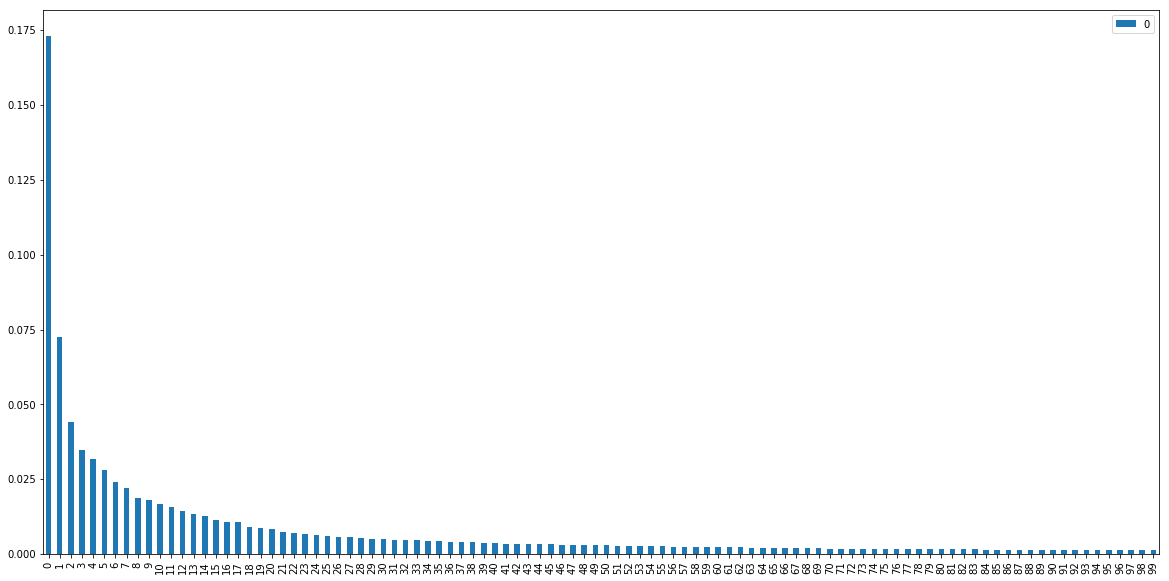

In [9]:
pd.DataFrame(bag_of_words_svd.explained_variance_ratio_).plot.bar(figsize=(20,10))

## 3.3 Visualization

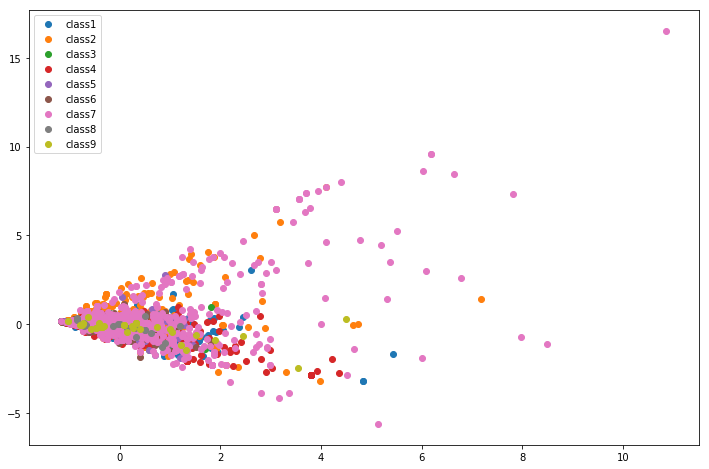

In [10]:
scaled_truncated_bag_of_words_with_labels = pd.DataFrame(scaled_truncated_bag_of_words).join(training_labels)

g = plt.figure(figsize=(12, 8)).gca()
for i in range(0, 9):
    df = scaled_truncated_bag_of_words_with_labels[(scaled_truncated_bag_of_words_with_labels['Class'] == i)]
    g.scatter(df[0], df[1],
              label='class' + str(i+1))
g.legend()
plt.show()

## 3.4 Prediction

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
X_train, X_test, y_train, y_test = train_test_split(scaled_truncated_bag_of_words, training_labels, test_size = 0.25, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)

test_log_loss = log_loss(y_test, y_pred)
print('log loss', test_log_loss)
print('accurancy', clf.score(X_test, y_test))

C:\Users\kingy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


log loss 1.02946168278
accurancy 0.622141997593


# 4 2-grams

## 4.1 Vectorization

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=None, max_features=None, ngram_range=(2, 2))

start = time()
two_grams = count_vectorizer.fit_transform(clean_text_column)
print('2 grams duration', time() - start, 'seconds')

2 grams duration 144.1770887374878 seconds


In [13]:
two_grams.shape

(3321, 2803700)

In [14]:
from sklearn.decomposition import TruncatedSVD
two_grams_svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
start = time()
truncated_two_grams = two_grams_svd.fit_transform(two_grams)
print('TruncatedSVD duration', time() - start, 'seconds')

TruncatedSVD duration 525.792977809906 seconds


In [15]:
truncated_two_grams.shape

(3321, 100)

In [16]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler().fit(truncated_two_grams)
scaled_truncated_two_grams = scaler.transform(truncated_two_grams)

## 4.2 Explained Variance Ratio

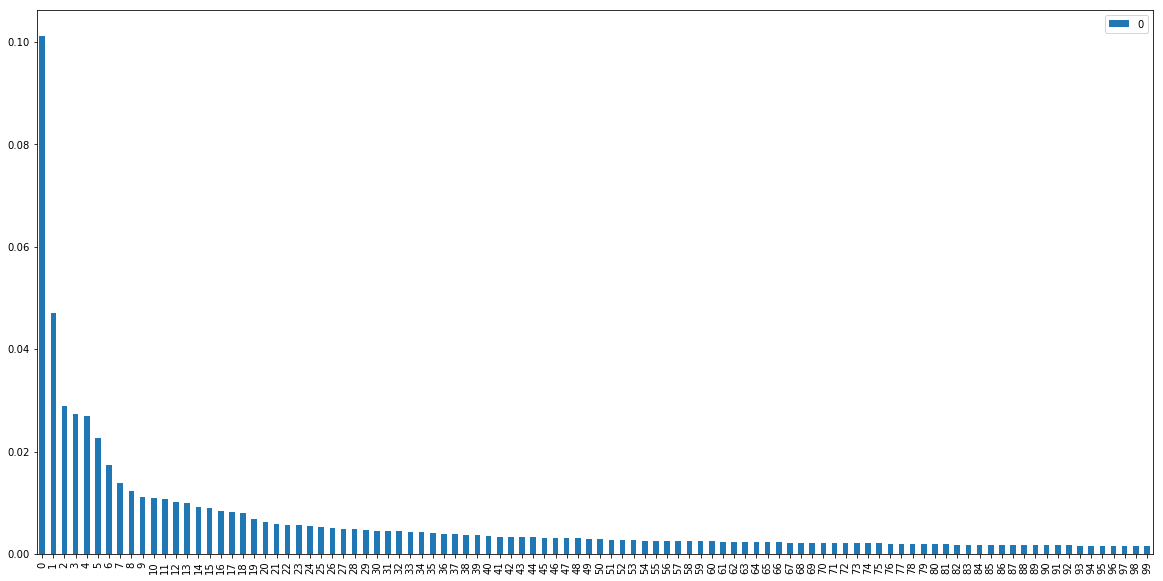

In [18]:
pd.DataFrame(two_grams_svd.explained_variance_ratio_).plot.bar(figsize=(20,10))

## 4.3 Visualization

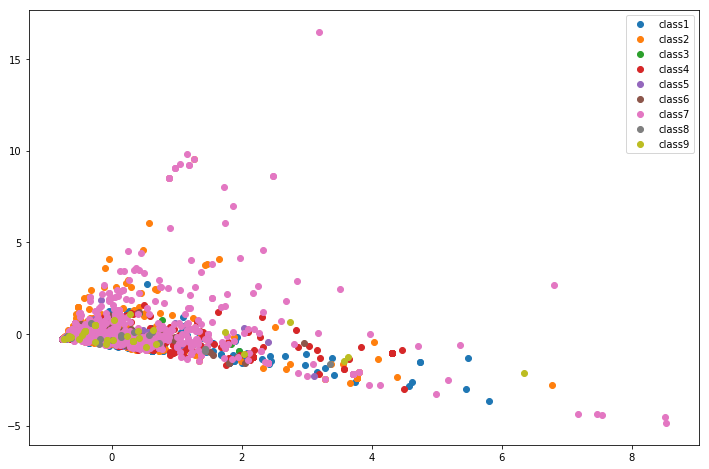

In [19]:
scaled_truncated_two_grams_with_labels = pd.DataFrame(scaled_truncated_two_grams).join(training_labels)

g = plt.figure(figsize=(12, 8)).gca()
for i in range(0, 9):
    df = scaled_truncated_two_grams_with_labels[(scaled_truncated_two_grams_with_labels['Class'] == i)]
    g.scatter(df[0], df[1],
              label='class' + str(i+1))
g.legend()
plt.show()

## 4.4 Prediction

In [20]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
X_train, X_test, y_train, y_test = train_test_split(scaled_truncated_two_grams, training_labels, test_size = 0.25, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)

test_log_loss = log_loss(y_test, y_pred)
print('log loss', test_log_loss)
print('accurancy', clf.score(X_test, y_test))

log loss 1.05060697235
accurancy 0.620938628159


# 5 tf-idf

## 5.1 Vectorization

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=None, max_features=None)

start = time()
text_tfid = vectorizer.fit_transform(clean_text_column)
print('tf-idf duration', time() - start, 'seconds')


tf-idf duration 112.07271909713745 seconds


In [22]:
text_tfid.shape

(3321, 153071)

In [23]:
tfid_svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
start = time()
truncated_text_tfid = tfid_svd.fit_transform(text_tfid)
print('TruncatedSVD duration', time() - start, 'seconds')

TruncatedSVD duration 57.10150384902954 seconds


In [24]:
truncated_text_tfid.shape

(3321, 100)

In [25]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler().fit(truncated_text_tfid)
scaled_truncated_text_tfid = scaler.transform(truncated_text_tfid)

## 5.2 Explained Variance Ratio

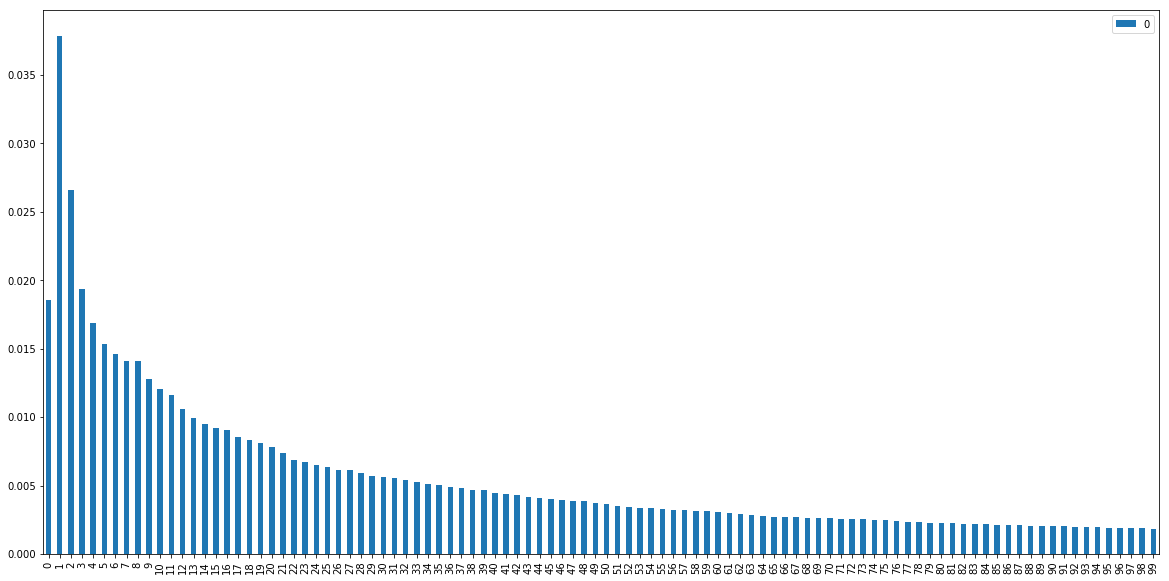

In [26]:
pd.DataFrame(tfid_svd.explained_variance_ratio_).plot.bar(figsize=(20,10))

## 5.3 Visualization

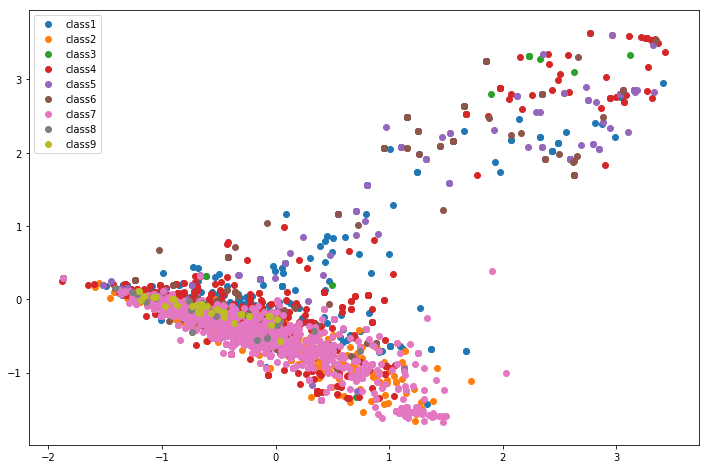

In [27]:
scaled_truncated_text_tfid_with_labels = pd.DataFrame(scaled_truncated_text_tfid).join(training_labels)

g = plt.figure(figsize=(12, 8)).gca()
for i in range(0, 9):
    df = scaled_truncated_text_tfid_with_labels[(scaled_truncated_text_tfid_with_labels['Class'] == i)]
    g.scatter(df[0], df[1],
              label='class' + str(i+1))
g.legend()
plt.show()

## 5.4 Prediction

In [28]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

X_train, X_test, y_train, y_test = train_test_split(scaled_truncated_text_tfid, training_labels, test_size = 0.25, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)

test_log_loss = log_loss(y_test, y_pred)
print('log loss', test_log_loss)
print('accurancy', clf.score(X_test, y_test))

log loss 1.02147688695
accurancy 0.6293622142


# 6 Doc2Vec

## 6.1 Training

In [29]:
import gensim
from nltk.corpus import stopwords
import nltk.data
import re

# English stop words
stops = set(stopwords.words("english"))

model_path = '../models/personalized_medicine.doc2vec'
model = None

# set it to false, if there is a saved model
train_new_model = False
vector_size = 500

if train_new_model:
    def get_text_lines_generator_for_doc2vec():
        for text in text_column:
            # Remove non-letters/digits
            text  = re.sub("[^a-zA-Z0-9]"," ", text)
            # Convert words to lower case
            words = text.lower().split()
            words = [w for w in words if not w in stops]
            text = ' '.join(words)
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(text), ['SEN_' + str(i)])
            
    text_lines_generator_for_doc2vec = get_text_lines_generator_for_doc2vec()   
    
    corpus = []
    for i in tqdm(range(len(text_column))):
        next_line = text_lines_generator_for_doc2vec.__next__()
        corpus.append(next_line)

C:\Users\kingy\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [30]:
if not train_new_model:
    # saved model
    doc2vec_model = gensim.models.doc2vec.Doc2Vec.load(model_path)
    print('Loaded a saved Doc2vec model.')
else:
    print('Training...')
    # train the model
    start = time()
    doc2vec_model = gensim.models.doc2vec.Doc2Vec(size=vector_size, min_count=2, iter=55)
    doc2vec_model.build_vocab(corpus)
    doc2vec_model.train(corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.iter)
    print('Building doc2vec model duration', time() - start, 'seconds')

    # save model
    doc2vec_model.save(model_path)
    print('Saved a Doc2vec model.')
    
doc_vector = doc2vec_model.infer_vector(['only', 'you', 'can', 'prevent', 'forrest', 'fires'])

print('Document Vector for', ['only', 'you', 'can', 'prevent', 'forrest', 'fires'])
print('Dimension', len(doc_vector))
print('First 5', doc_vector[:5])

Loaded a saved Doc2vec model.
Document Vector for ['only', 'you', 'can', 'prevent', 'forrest', 'fires']
Dimension 500
First 5 [ 0.03413824 -0.10554381  0.05196161 -0.0064119   0.00469881]


## 6.2 Vectorization

In [39]:
# set it to false, if there is a transformed text file
transform_new_vectors = False

train_document_vectors_path = '../datasets/train_doc_vec' 
submission_document_vectors_path = '../datasets/submission_doc_vec' 

if not transform_new_vectors:
    train_document_vectors = pd.read_csv(train_document_vectors_path, sep=',')
    submission_document_vectors = pd.read_csv(submission_document_vectors_path, sep=',')
else:
    def get_doc2vec_generator(texts):
        for text in texts:
            # Remove non-letters/digits
            text  = re.sub("[^a-zA-Z0-9]"," ", text)
            # Convert words to lower case
            words = text.lower().split()
            words = [w for w in words if not w in stops]
            text = ' '.join(words)
            yield  doc2vec_model.infer_vector(gensim.utils.simple_preprocess(text))

    train_doc2vec_generator = get_doc2vec_generator(train_text_column)
    submission_doc2vec_generator = get_doc2vec_generator(submission_text_column)
    
    train_document_vectors = pd.DataFrame(columns=['ID'] + list(range(vector_size)))
    submission_document_vectors = pd.DataFrame(columns=['ID'] + list(range(vector_size)))
    
    print('Train text Doc2vec...')
    for i in tqdm(range(len(train_text_column))):
        train_document_vectors.loc[i] = np.append([i], train_doc2vec_generator.__next__())
        
    print('Submission text Doc2vec...')
    for i in tqdm(range(len(submission_text_column))):
        submission_document_vectors.loc[i] = np.append([i], submission_doc2vec_generator.__next__())
        
    train_document_vectors.to_csv(train_document_vectors_path, sep=',',index=False)
    submission_document_vectors.to_csv(submission_document_vectors_path, sep=',', index=False)
    

display(train_document_vectors)
display(submission_document_vectors)
train_document_vectors_without_ID = train_document_vectors.drop('ID', axis = 1)

,ID,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,0.0,-0.077138,-1.254977,-0.473477,-0.293658,-1.049927,-0.697054,-1.828044,1.537095,1.350821,...,-0.048696,1.235324,0.705763,0.995673,0.633155,-0.741721,0.778489,1.133787,-0.946999,0.651891
1,1.0,0.882235,0.242380,0.817193,-0.980499,-0.214879,-1.248003,0.785030,2.328046,0.739947,...,0.326776,-0.217447,0.499960,-0.807205,-1.064548,-0.081534,0.063459,0.606765,-0.103779,0.940034
2,2.0,0.147658,0.272967,0.505897,-0.714064,0.041757,-0.987850,0.376290,2.432467,0.969738,...,0.254495,-0.285934,0.157587,-0.918103,-1.068257,0.657361,-0.165605,1.407855,-0.176858,0.131010
3,3.0,-0.232573,-0.095612,0.071075,0.284738,0.169839,1.283495,1.002586,0.513112,0.554289,...,-0.999952,0.860151,-0.503708,-0.439715,0.353333,0.078244,-0.886655,-0.872907,-0.473709,-0.259829
4,4.0,0.394327,0.242793,0.245565,1.020949,1.651048,-1.744010,-0.333898,1.975598,1.700948,...,1.091933,-0.066347,-0.031193,-1.301661,-0.690693,0.355076,0.192479,1.705503,-0.546681,-0.317650
5,5.0,0.805445,0.493622,0.478982,1.260363,0.945773,-1.112672,0.103715,1.837921,1.359798,...,2.148201,0.198734,0.276907,-0.844252,-0.273915,-0.007758,-0.281026,1.487536,-0.377521,-0.780964
6,6.0,0.571791,0.248851,-0.154292,0.615626,1.258198,-1.798354,0.235662,2.011043,1.364999,...,1.789204,-0.411253,-0.029721,-0.909403,-0.938156,0.346946,-0.331204,1.869636,-0.465147,-0.473962
7,7.0,-0.825483,-2.205589,-0.478353,-0.562854,-0.514684,-0.013522,-0.031492,0.679691,-0.740080,...,-1.082419,-0.669798,0.745346,2.022462,-0.102329,0.839764,-0.538000,0.666319,1.241037,0.346234
8,8.0,0.974204,-0.256133,0.407240,0.261944,0.720578,-2.003942,0.030666,1.239654,2.667618,...,1.426229,0.609577,0.695933,-0.008525,-2.259398,0.906233,0.299792,1.673474,-0.397972,0.167837
9,9.0,-0.635332,-0.152148,0.163932,0.379307,-0.435297,-0.955571,0.119274,-0.018376,1.765166,...,-0.811389,0.820605,0.429403,0.525523,-1.171883,0.853135,0.245444,0.024519,-0.189665,0.690133


,ID,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.204868,0.460207,-0.231745,0.598812,0.129328,1.063806,-1.051604,0.911937,0.376510,...,-0.376806,0.441224,-0.108624,0.215553,0.257528,0.667158,-0.890251,-0.772993,-0.150516,0.648037
1,1.0,-0.344778,-1.289598,0.628350,-0.550818,0.102811,-0.296028,0.269032,0.438052,0.382243,...,0.126183,0.000417,-0.622767,-1.198836,-0.116282,-0.011193,1.441819,1.928084,-2.025862,-0.151967
2,2.0,-0.922570,1.225973,-1.632470,1.034599,1.486071,-1.075069,-0.349424,2.564479,-0.047349,...,0.874669,-0.008295,-0.251190,-0.036539,-1.127005,-0.276222,-0.644885,1.650424,-0.027076,-0.975785
3,3.0,-1.978310,-1.297378,1.223150,0.097772,0.046544,-0.351502,-0.026714,0.196623,-0.147825,...,-0.634108,1.290179,2.091070,-0.702023,0.067824,0.706089,-1.194018,0.636138,-0.909353,0.590281
4,4.0,-0.316630,-0.714140,-1.420592,0.942108,0.795462,0.619021,-0.159777,1.038406,-0.131785,...,-0.324290,0.164871,1.594435,-0.075948,0.458423,1.173828,-0.891413,-1.063247,0.007643,-1.081472
5,5.0,0.029394,1.583765,0.911353,1.409701,0.205578,0.804775,0.234437,-0.648293,-0.061630,...,1.282212,-0.264628,0.752034,0.817462,0.845397,0.226845,-0.526350,-0.107110,-0.946403,-0.392888
6,6.0,0.927641,1.153129,0.476124,1.030253,-1.027331,1.176708,-0.336639,0.838136,-1.321943,...,0.592106,-1.232004,0.820687,-2.060165,-1.265084,1.596002,-1.749188,0.708709,-1.118067,-1.507500
7,7.0,1.751361,1.241367,0.536750,0.098638,-0.197416,-0.769428,-0.316322,1.421919,1.493024,...,1.258657,-0.569439,-0.376988,0.033975,-0.558305,0.087889,0.074816,0.421365,-0.170359,-1.145659
8,8.0,-0.634948,1.130092,0.956752,0.030438,1.191581,-0.702532,-2.294811,0.913049,-0.125282,...,1.114643,0.169463,-0.827596,0.322481,-0.083595,-0.004325,0.344415,1.524223,-0.226418,-0.182851
9,9.0,0.544546,0.693650,-0.947940,0.212437,0.863167,0.767963,0.326787,0.833779,-0.038105,...,-0.660948,-0.579210,1.906255,-0.581887,0.822869,2.407080,-1.834118,1.355882,0.607517,0.059399


## 6.3 Visualization

In [40]:
from sklearn.manifold import TSNE

start = time()
train_document_vectors_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(train_document_vectors_without_ID))

print('TSNE duration', time() - start, 'seconds')

TSNE duration 112.91627669334412 seconds


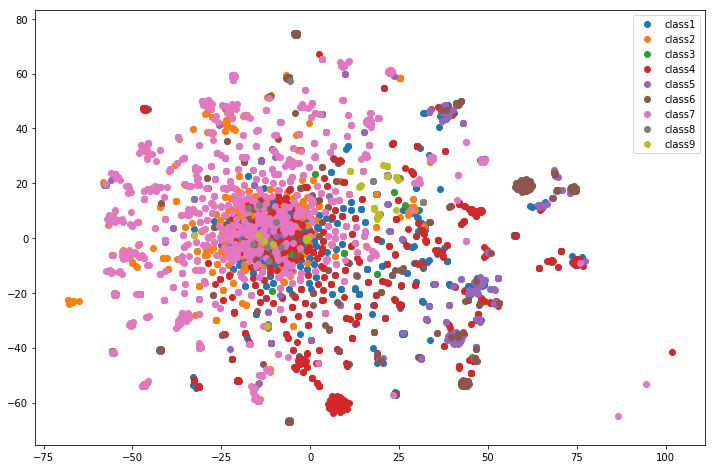

In [41]:
draw_df = train_document_vectors_tsne.join(training_labels)

g = plt.figure(figsize=(12, 8)).gca()
for i in range(0, 9):
    df = draw_df[(draw_df['Class'] == i)]
    g.scatter(df[0], df[1], 
              label='class' + str(i+1))
g.legend()
plt.show()

## 6.4 Prediction

In [42]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

X_train, X_test, y_train, y_test = train_test_split(train_document_vectors_without_ID, training_labels, test_size = 0.25, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)

test_log_loss = log_loss(y_test, y_pred)
print('log loss', test_log_loss)
print('accurancy', clf.score(X_test, y_test))

log loss 1.20519936077
accurancy 0.595667870036
